In [45]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd
import requests
import random
from datetime import datetime
import threading
import os
import matplotlib.pyplot as plt
import re
import shutil

In [15]:
WAIT_TIME = 100
SCROLL_PAUSE_TIME = 3

In [16]:
# Search parameters
# If you want to test with other routes and dates, you can add them as a dictionary here, with the same parameters
search_parameters = [
        {
            "SOURCE_COUNTRY" : 'sin',
            "DEST_COUNTRY" : 'mil',
            "FROM_DATE" : '2025-06-25',
            "END_DATE" : '2025-07-04',
            "NUM_ADULTS" : '1',
            "TRIP_TYPE" : 'rt'
        },
        {
            "SOURCE_COUNTRY" : 'mil',
            "DEST_COUNTRY" : 'ams',
            "FROM_DATE" : '2025-08-03',
            "END_DATE" : '2025-08-24',
            "NUM_ADULTS" : '1',
            "TRIP_TYPE" : 'rt'
        },
        {
            "SOURCE_COUNTRY" : 'ams',
            "DEST_COUNTRY" : 'san',
            "FROM_DATE" : '2025-09-13',
            "END_DATE" : '2025-09-29',
            "NUM_ADULTS" : '1',
            "TRIP_TYPE" : 'rt'
        },
        {
            "SOURCE_COUNTRY" : 'ams',
            "DEST_COUNTRY" : 'sin',
            "FROM_DATE" : '2025-09-13',
            "END_DATE" : '2025-09-29',
            "NUM_ADULTS" : '1',
            "TRIP_TYPE" : 'rt'
        }
    ]

In [17]:
chromedriver_path = shutil.which("chromedriver")
service = Service(chromedriver_path)
options = webdriver.ChromeOptions()

In [18]:
def detect_captcha(driver):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    time.sleep(5)
    if soup.find('div', id='verification-pop'):
        print('Captcha detected. Please solve it manually now.')
        time.sleep(random.uniform(5, 10))
        return True
    return False

def detect_refresh_button(driver):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    time.sleep(5)
    elem = soup.find('span', _class='ift-modal-bottom__btn flex-center ift-modal-bottom__yes  ThemeHoverBG2')
    if elem:
        elem.click()


def check_periodically_for_captcha(driver, interval=2):
    while True:
        try:
            detect_captcha(driver)
        except:
            print("WebDriver session has closed. Stopping captcha thread.")
            break
        time.sleep(interval)

def check_periodically_for_refresh_button(driver, interval=2):
    while True:
        try:
            detect_refresh_button(driver)
        except:
            print("WebDriver session has closed. Stopping refresh thread.")
            break
        time.sleep(interval)

In [19]:
def return_html_from_search(search_info_dict:dict):
    driver = webdriver.Chrome(service=service, options=options)
    SOURCE_COUNTRY = search_info_dict['SOURCE_COUNTRY']
    DEST_COUNTRY = search_info_dict['DEST_COUNTRY']
    FROM_DATE = search_info_dict['FROM_DATE']
    END_DATE = search_info_dict['END_DATE']
    TRIP_TYPE = search_info_dict['TRIP_TYPE']
    NUM_ADULTS = search_info_dict['NUM_ADULTS']

    url = f'https://sg.trip.com/flights/showfarefirst?dcity={SOURCE_COUNTRY}&acity={DEST_COUNTRY}&ddate={FROM_DATE}&rdate={END_DATE}&triptype={TRIP_TYPE}&quantity={NUM_ADULTS}'
    print(url)

    # Detect rate limiting and retry if error code is 429, which is for too many requests
    response = requests.get(url)
    if response.status_code == 429:
        retry_after = int(response.headers.get("Retry-After", 10))
        time.sleep(retry_after)

    driver.get(url)

    # Background thread to detect if captcha has appeared and prompt user to solve them
    captcha_thread = threading.Thread(
        target=check_periodically_for_captcha,
        args=(driver,),
        daemon=True
    )
    captcha_thread.start()

    # Background thread to detect if automatically close popup which prompts users to 'refresh' the page
    refresh_button_thread = threading.Thread(
        target=check_periodically_for_refresh_button,
        args=(driver,),
        daemon=True
    )
    refresh_button_thread.start()
    
    time.sleep(10)
    
    windows = driver.window_handles
    driver.switch_to.window(windows[-1])

    print(f'Scraping {driver.title}...')

    # The website loads data as you scroll down. To simulate that and get all results, we keep scrolling down until we cant scroll anymore
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait for new content to load
        time.sleep(SCROLL_PAUSE_TIME)

        # Check new scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")

        if new_height == last_height:
            print("Reached the bottom. No more data to load.")
            break

        last_height = new_height

    # This html class data-toast-title only appears when all flight results have been loaded on the website. 
    # We wait until this toast appears within the html
    wait = WebDriverWait(driver, WAIT_TIME)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, '[data-toast-title="All flight results loaded"]')))

    # Sleep while data is still rendering on the page
    time.sleep(WAIT_TIME)

    # this class list-placeholder-v2.list-placeholder-v2__loading is a placeholder class until a row of flight results is being loaded
    # We try to wait until all of them are loaded, but if not loaded by a predetermined time, we take the rows of flight results that have been loaded
    # This is done by attempting to wait until all instances of the placeholder class name disappear from the html
    try:
        wait.until(
            EC.invisibility_of_element_located(
                (By.CSS_SELECTOR, ".list-placeholder-v2.list-placeholder-v2__loading")
            )
        )
    except:
        print('not all results loaded')

    # Parse HTML with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    driver.quit()
    return soup

In [20]:
def return_dataframe_of_scraped_results(soup):
    scraped_results = []
    m_result_div = soup.find("div", class_ = "m-result-list")
    flight_divs = m_result_div.find_all("div", attrs={"data-flight-id": True})

    for flight_div in flight_divs:
        try:
            flight_info_output = {}
            flight_info_list_div = flight_div.find("div", class_="flight-info-list")
            airline_name_div = flight_info_list_div.find("div", class_ = "flight-info is-v2")
            airline_name = airline_name_div.get('aria-label')
            flight_info_output['airline_name'] = airline_name.strip()
            name_of_airline_div = flight_info_list_div.find("div", class_ = "flight-info-col col-1")
            date_and_time_of_flight_div = flight_info_list_div.find("div", class_ = "flight-info-col col-2")
            time_divs = date_and_time_of_flight_div.find_all("span", class_ = "time_cbcc")
            flight_info_output['departure_time'] = time_divs[0].get("data-testid")[12:]
            flight_info_output['arrival_time'] = time_divs[1].get("data-testid")[12:]
            terminal_divs = date_and_time_of_flight_div.find_all("span", class_ = "flight-info-stop__code_e162")
            flight_info_output['departure_terminal'] = terminal_divs[0].get_text(strip=True)
            flight_info_output['arrival_terminal'] = terminal_divs[1].get_text(strip=True)
            mode_of_transport_div = date_and_time_of_flight_div.find("span", class_ = "flight-info-stop__text_3ee2")
            flight_info_output['Way_Of_Travel'] = mode_of_transport_div.get('aria-label')
            travel_time_in_hours_div = date_and_time_of_flight_div.find("div", class_ = "flight-info-duration_576d")
            flight_info_output['Time in Hours'] = travel_time_in_hours_div.get_text(strip=True)
            days_added_div = flight_div.find('sup', class_ = 'flight-info-stop__timer-dayplus_0714')
            days_added_text = ''
            if days_added_div:
                days_added_text = days_added_div.get_text(strip=True)
            flight_info_output['number_days_added'] = days_added_text
            trip_type_div = flight_div.find("div", class_="item-con-price__tag")
            flight_info_output['Trip_Type'] = trip_type_div.get_text(strip=True)

            checked_baggage_text = ''
            checked_baggage_div_parent = flight_div.find('span', class_ = 'flight-tag_1066 flight-tag--green_6e73')

            if checked_baggage_div_parent:
                checked_baggage_div = checked_baggage_div_parent.find('span', class_ = 'text')
                if checked_baggage_div:
                    checked_baggage_text = checked_baggage_div.get_text(strip=True)
            flight_info_output['free_checked_baggage'] = checked_baggage_text

            limited_tickets_remaining_text = ''
            limited_tickets_remaining_div = flight_div.find('span', class_ = 'book-btn-left f-12')
            if limited_tickets_remaining_div:
                limited_tickets_remaining_text = limited_tickets_remaining_div.get_text(strip=True)
            flight_info_output['limited_tickets_remaining?'] = limited_tickets_remaining_text
            

            price_div = flight_div.find("span", class_="ThemeColor8 f-20 o-price-flight_b825 no-cursor_1b76")
            flight_info_output['Price'] = '$' + price_div.get('data-price')

            scraped_results.append(flight_info_output)
        except Exception as e:
            # if the html parsing fails, it means the row's html had not been loaded yet, so we skip this row as it would not contain the html elements required and cause errors
            continue
    output_df = pd.DataFrame(scraped_results)
    output_df = output_df.drop_duplicates()
    output_df = output_df.reset_index(drop=True)

    # To reflect less bot like behaviour, use a randomized delay
    time.sleep(random.uniform(1.5, 3.5))
    return output_df

In [21]:
merged_dataframe = pd.DataFrame()
for search_info_dict in search_parameters:
    soup = return_html_from_search(search_info_dict)
    data_frame_from_search = return_dataframe_of_scraped_results(soup)
    merged_dataframe = pd.concat([merged_dataframe, data_frame_from_search], ignore_index=True)

https://sg.trip.com/flights/showfarefirst?dcity=sin&acity=mil&ddate=2025-06-25&rdate=2025-07-04&triptype=rt&quantity=1
Scraping Flights from Singapore to Milan | Trip.com...
Captcha detected. Please solve it manually now.
Reached the bottom. No more data to load.
not all results loaded
WebDriver session has closed. Stopping refresh thread.
WebDriver session has closed. Stopping captcha thread.
https://sg.trip.com/flights/showfarefirst?dcity=mil&acity=ams&ddate=2025-08-03&rdate=2025-08-24&triptype=rt&quantity=1
Scraping Flights from Milan to Amsterdam | Trip.com...
Captcha detected. Please solve it manually now.
Reached the bottom. No more data to load.
not all results loaded
https://sg.trip.com/flights/showfarefirst?dcity=ams&acity=san&ddate=2025-09-13&rdate=2025-09-29&triptype=rt&quantity=1
WebDriver session has closed. Stopping refresh thread.
WebDriver session has closed. Stopping captcha thread.
Scraping Flights from Amsterdam to San Diego | Trip.com...
Captcha detected. Please sol

In [23]:
merged_dataframe

,airline_name,departure_time,arrival_time,departure_terminal,arrival_terminal,Way_Of_Travel,Time in Hours,number_days_added,Trip_Type,free_checked_baggage,limited_tickets_remaining?,Price
0,Singapore Airlines,2025-06-25 23:30:00,2025-06-26 06:30:00,SIN T3,MXP T1,Direct,13h,+1,Return,Checked baggage 25 kg,,$1598
1,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 00:55:00,2025-06-25 19:35:00,SIN T3,MXP T1,7h in Shanghai,24h 40m,,Return,Checked baggage 23 kg,,$917
2,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 14:20:00,2025-06-26 20:00:00,SIN T3,MXP T1,17h 50m in Xi'an,35h 40m,+1,Return,Checked baggage 23 kg,,$917
3,"Air China ,Air China Transfer in Shanghai...",2025-06-25 17:30:00,2025-06-26 08:05:00,SIN T1,MXP T1,2h 15m in Shanghai,20h 35m,+1,Return,Checked baggage 2 x 23 kg,,$921
4,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 23:10:00,2025-06-26 19:35:00,SIN T3,MXP T1,8h 40m in Shanghai,26h 25m,+1,Return,Checked baggage 23 kg,,$946
...,...,...,...,...,...,...,...,...,...,...,...,...
85,"Emirates ,Emirates Transfer in Dubai 3h 35m",2025-09-13 21:50:00,2025-09-14 21:45:00,AMS,SIN T1,3h 35m in Dubai,17h 55m,+1,Return,,,$1521
86,"Garuda Indonesia ,Garuda Indonesia Transf...",2025-09-13 12:05:00,2025-09-14 11:40:00,AMS,SIN T3,1h in Jakarta,17h 35m,+1,Return,,<5 left,$1536
87,"Garuda Indonesia ,Garuda Indonesia Transf...",2025-09-13 12:05:00,2025-09-14 14:35:00,AMS,SIN T3,3h 55m in Jakarta,20h 30m,+1,Return,,<5 left,$1536
88,"Cathay Pacific ,Cathay Pacific Transfer i...",2025-09-13 12:15:00,2025-09-14 11:45:00,AMS,SIN T4,1h 50m in Hong Kong,17h 30m,+1,Return,,,$1573


In [24]:
# Perfrom some data processing on the dataframe, adding additional fields
def get_num_airlines(airline_name):
    if ',' not in airline_name:
        return 'Singular Airline'
    return 'Multiple Airlines'

merged_dataframe['departure_time'] = pd.to_datetime(merged_dataframe['departure_time'], format="%Y-%m-%d %H:%M:%S")
merged_dataframe['arrival_time'] = pd.to_datetime(merged_dataframe['arrival_time'], format="%Y-%m-%d %H:%M:%S")
merged_dataframe['number_of_airlines'] = merged_dataframe['airline_name'].apply(get_num_airlines)
merged_dataframe

,airline_name,departure_time,arrival_time,departure_terminal,arrival_terminal,Way_Of_Travel,Time in Hours,number_days_added,Trip_Type,free_checked_baggage,limited_tickets_remaining?,Price,number_of_airlines
0,Singapore Airlines,2025-06-25 23:30:00,2025-06-26 06:30:00,SIN T3,MXP T1,Direct,13h,+1,Return,Checked baggage 25 kg,,$1598,Singular Airline
1,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 00:55:00,2025-06-25 19:35:00,SIN T3,MXP T1,7h in Shanghai,24h 40m,,Return,Checked baggage 23 kg,,$917,Multiple Airlines
2,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 14:20:00,2025-06-26 20:00:00,SIN T3,MXP T1,17h 50m in Xi'an,35h 40m,+1,Return,Checked baggage 23 kg,,$917,Multiple Airlines
3,"Air China ,Air China Transfer in Shanghai...",2025-06-25 17:30:00,2025-06-26 08:05:00,SIN T1,MXP T1,2h 15m in Shanghai,20h 35m,+1,Return,Checked baggage 2 x 23 kg,,$921,Multiple Airlines
4,"China Eastern Airlines ,China Eastern Airlines...",2025-06-25 23:10:00,2025-06-26 19:35:00,SIN T3,MXP T1,8h 40m in Shanghai,26h 25m,+1,Return,Checked baggage 23 kg,,$946,Multiple Airlines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,"Emirates ,Emirates Transfer in Dubai 3h 35m",2025-09-13 21:50:00,2025-09-14 21:45:00,AMS,SIN T1,3h 35m in Dubai,17h 55m,+1,Return,,,$1521,Multiple Airlines
86,"Garuda Indonesia ,Garuda Indonesia Transf...",2025-09-13 12:05:00,2025-09-14 11:40:00,AMS,SIN T3,1h in Jakarta,17h 35m,+1,Return,,<5 left,$1536,Multiple Airlines
87,"Garuda Indonesia ,Garuda Indonesia Transf...",2025-09-13 12:05:00,2025-09-14 14:35:00,AMS,SIN T3,3h 55m in Jakarta,20h 30m,+1,Return,,<5 left,$1536,Multiple Airlines
88,"Cathay Pacific ,Cathay Pacific Transfer i...",2025-09-13 12:15:00,2025-09-14 11:45:00,AMS,SIN T4,1h 50m in Hong Kong,17h 30m,+1,Return,,,$1573,Multiple Airlines


In [30]:
time_now = datetime.now()
output_folder_path = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
file_name = os.path.join(output_folder_path, f'{time_now}_scraping_results_trip.csv')
merged_dataframe.to_csv(file_name, index=False)

Exploratory Data Analysis

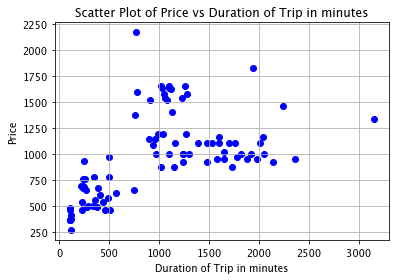

In [47]:
# Plot price against total flight duration in hours
def strip_dollar_convert_int(price):
    if type(price) == int:
        return price
    price = price[1:]
    return int(price)

def convert_time_to_minutes(time):
    if type(time) == int:
        return time
    match = re.match(r"(?:(\d+)h)?\s*(?:(\d+)m)?", time)
    hours = int(match.group(1) or 0)
    minutes = int(match.group(2) or 0)
    total_minutes = hours * 60 + minutes
    return total_minutes

merged_dataframe['Price'] = merged_dataframe['Price'].apply(strip_dollar_convert_int)
merged_dataframe['Duration of Trip in minutes'] = merged_dataframe['Time in Hours'].apply(convert_time_to_minutes)


plt.scatter(merged_dataframe['Duration of Trip in minutes'], merged_dataframe['Price'], color='blue')
plt.title("Scatter Plot of Price vs Duration of Trip in minutes")
plt.xlabel("Duration of Trip in minutes")
plt.ylabel("Price")
plt.grid(True)
plt.show()

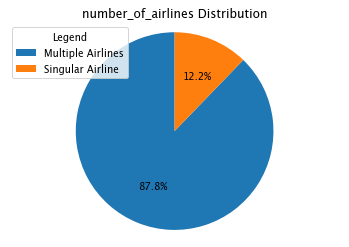

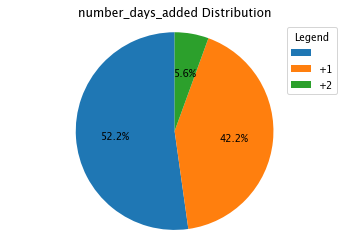

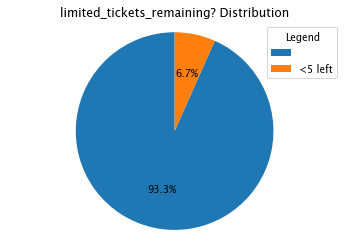

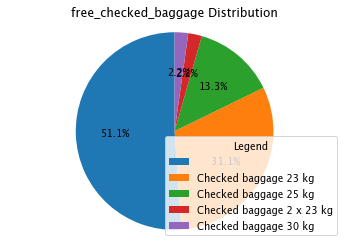

In [48]:
for col in ['number_of_airlines', 'number_days_added', 'limited_tickets_remaining?', 'free_checked_baggage']:
    counts = merged_dataframe[col].value_counts()
    counts.plot.pie(labels=None, autopct='%1.1f%%', startangle=90, ylabel='', title='Status Distribution')
    plt.title(f'{col} Distribution')
    plt.legend(labels=counts.index, loc='best', title="Legend")
    plt.axis('equal')
    plt.show()